In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

In [2]:
# Mengatur folder path dari Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Path ke dataset di Google Drive
base_path = "/content/gdrive/MyDrive/Dataset Tuberkulosis"
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
val_path = os.path.join(base_path, "Val")

In [4]:
# Inisialisasi generator untuk training data
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalisasi nilai pixel menjadi 0-1
    shear_range=0.1,           # Sudut potongan gambar
    zoom_range=0.1,            # Rentang zoom gambar
)



train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Inisialisasi generator untuk validation data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Inisialisasi generator untuk validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 5440 images belonging to 2 classes.
Found 1020 images belonging to 2 classes.
Found 340 images belonging to 2 classes.


In [5]:
# Inisialisasi model
model = Sequential()

# Convolution layer dan Pooling Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dropout(0.5))  # Dropout layer dengan rate 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Output layer dengan 2 neuron menggunakan softmax

In [6]:
# Menggunakan optimizer RMSprop dengan learning rate 0.01
optimizer = RMSprop(learning_rate=0.001)

# Kompilasi model dengan optimizer yang ditentukan
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model dengan early stopping
history = model.fit(train_generator, epochs=30, validation_data=test_generator)

Epoch 1/30
340/340 [==============================] - 1145s 3s/step - loss: 0.3448 - accuracy: 0.8649 - val_loss: 0.2524 - val_accuracy: 0.8706
Epoch 2/30
340/340 [==============================] - 121s 355ms/step - loss: 0.1738 - accuracy: 0.9336 - val_loss: 0.2030 - val_accuracy: 0.9108
Epoch 3/30
340/340 [==============================] - 121s 357ms/step - loss: 0.1358 - accuracy: 0.9485 - val_loss: 0.1764 - val_accuracy: 0.9373
Epoch 4/30
340/340 [==============================] - 120s 354ms/step - loss: 0.1101 - accuracy: 0.9585 - val_loss: 0.2315 - val_accuracy: 0.9206
Epoch 5/30
340/340 [==============================] - 121s 356ms/step - loss: 0.0962 - accuracy: 0.9638 - val_loss: 0.4408 - val_accuracy: 0.8627
Epoch 6/30
340/340 [==============================] - 121s 356ms/step - loss: 0.0928 - accuracy: 0.9678 - val_loss: 0.1385 - val_accuracy: 0.9588
Epoch 7/30
340/340 [==============================] - 120s 353ms/step - loss: 0.0978 - accuracy: 0.9713 - val_loss: 0.1139 - v

In [7]:
# Evaluasi model
val_generator.reset()
Y_val_pred = model.predict(val_generator)
y_val_pred = np.argmax(Y_val_pred, axis=1)
y_val_true = val_generator.classes

22/22 [==============================] - 88s 4s/step


In [8]:
# Hitung confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Hitung akurasi, presisi, recall, dan f1-score
accuracy = accuracy_score(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred, target_names=['Normal', 'Tuberkulosis'])

# Tambahkan akurasi ke dalam laporan klasifikasi
report += f"\nAccuracy: {accuracy:.2f}"

# Tampilkan laporan klasifikasi yang sudah termasuk akurasi
print("Classification Report:")
print(report)

Confusion Matrix:
[[167   3]
 [  5 165]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98       170
Tuberkulosis       0.98      0.97      0.98       170

    accuracy                           0.98       340
   macro avg       0.98      0.98      0.98       340
weighted avg       0.98      0.98      0.98       340

Accuracy: 0.98


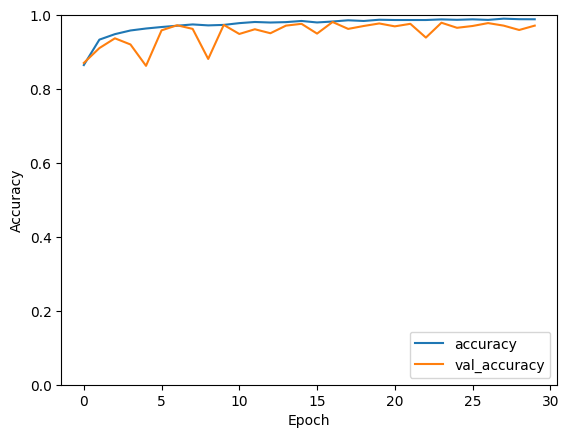

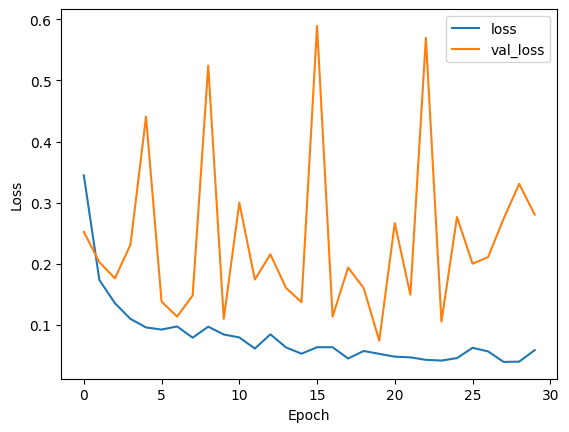

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot accuracy dan loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# Menambahkan plot loss
plt.figure()  # Membuat figure baru untuk plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [10]:
# Simpan model ke file .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = "/content/gdrive/MyDrive/Dataset Tuberkulosis/modelkonfigurasi3.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print("Model berhasil disimpan sebagai model.tflite di Google Drive.")

Model berhasil disimpan sebagai model.tflite di Google Drive.
